In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import glob
import os

files = os.path.join("C:\\Users\\Adesh Suri\\Desktop\\angel", "bq-markov*.csv")

files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

df = pd.concat(map(pd.read_csv, files), ignore_index=True)

#df = pd.read_csv('bq-Markov1.csv')
df = df.sort_values(['visitStartTime'],
                    ascending=[True])
df['visit_order'] = df.groupby('AUC_Code').cumcount() + 1

Resultant CSV after joining all CSV files at a particular location...


In [2]:
df

,date,Session_ID,AUC_Code,visitStartTime,source,mx_AngelCode,conv_date,Conversion,visit_order
4173501,2022-01-01,9.659566e+18,AIB40503-0000,1640975400,google-play,AIB40503-0000,2022-01-09,1,1
402003,2022-01-01,1.328265e+19,AIB43825-0000,1640975400,(not set),AIB43825-0000,2022-01-01,1,1
4514772,2022-01-01,7.230832e+18,AIB44054-0000,1640975400,google-play,NaN,NaN,0,1
8069905,2022-01-01,6.790723e+16,AIB39927-0000,1640975400,(not set),NaN,NaN,0,1
710727,2022-01-01,7.109435e+18,ACG74095-0000,1640975401,google-play,ACG74095-0000,2022-01-01,1,1
...,...,...,...,...,...,...,...,...,...
49125947,2022-05-31,1.402818e+19,ACG16380-0000,1654021795,(direct),NaN,NaN,0,56
55104950,2022-05-31,1.048319e+19,AHF02364-0000,1654021795,(direct),NaN,NaN,0,54
54052360,2022-05-31,9.053891e+18,AEI42250-0000,1654021797,(direct),NaN,NaN,0,67
55090189,2022-05-31,4.287868e+18,AHQ47276-0000,1654021799,(direct),NaN,NaN,0,97


In [3]:
cols = ['(not set)',
'google-play',
'(direct)',
'(not%20set)',
'google',
'youtube.com',
'web',
#'THTNO_Digital',
#'BNPFH_Digital',
#'SMS',
#'l.instagram.com',
#'sms',
#'stepupnetwork.in',
#'deals102',
#'menu',
#'OTOPI_Digital',
#'apps.facebook.com',
#'www-angelone-in.cdn.ampproject.org',
#'RnE'
]

df['source'].loc[df['source'].apply(lambda x: (x not in cols) )] = 'Others'


C:\Users\Adesh Suri\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
df

,date,Session_ID,AUC_Code,visitStartTime,source,mx_AngelCode,conv_date,Conversion,visit_order
4173501,2022-01-01,9.659566e+18,AIB40503-0000,1640975400,google-play,AIB40503-0000,2022-01-09,1,1
402003,2022-01-01,1.328265e+19,AIB43825-0000,1640975400,(not set),AIB43825-0000,2022-01-01,1,1
4514772,2022-01-01,7.230832e+18,AIB44054-0000,1640975400,google-play,NaN,NaN,0,1
8069905,2022-01-01,6.790723e+16,AIB39927-0000,1640975400,(not set),NaN,NaN,0,1
710727,2022-01-01,7.109435e+18,ACG74095-0000,1640975401,google-play,ACG74095-0000,2022-01-01,1,1
...,...,...,...,...,...,...,...,...,...
49125947,2022-05-31,1.402818e+19,ACG16380-0000,1654021795,(direct),NaN,NaN,0,56
55104950,2022-05-31,1.048319e+19,AHF02364-0000,1654021795,(direct),NaN,NaN,0,54
54052360,2022-05-31,9.053891e+18,AEI42250-0000,1654021797,(direct),NaN,NaN,0,67
55090189,2022-05-31,4.287868e+18,AHQ47276-0000,1654021799,(direct),NaN,NaN,0,97


In [5]:
df_paths = df.groupby('AUC_Code')['source'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
    
df_last_interaction = df.drop_duplicates('AUC_Code', keep='last')[['AUC_Code', 'Conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='AUC_Code')

df_paths['path'] = np.where( df_paths['Conversion'] == 0,
['Start, '] + df_paths['source'].apply(', '.join) + [', Null'],
['Start, '] + df_paths['source'].apply(', '.join) + [', Conversion'])


df_paths['path'] = df_paths['path'].str.split(', ')

df_paths = df_paths[['AUC_Code', 'path']]

In [6]:
df_paths

,AUC_Code,path
0,AAA00003-0000,"[Start, Others, (direct), Null]"
1,AAA00099-0000,"[Start, (not set), (direct), Null]"
2,AAA00195-0000,"[Start, youtube.com, Null]"
3,AAA00209-0000,"[Start, Others, Null]"
4,AAA00369-0000,"[Start, google, Null]"
...,...,...
5735760,SP50006838,"[Start, (direct), Null]"
5735761,SP50006842,"[Start, (direct), Null]"
5735762,SPAI2824357501,"[Start, (direct), Null]"
5735763,SPLM07372376,"[Start, (direct), Null]"


In [7]:
count=0
for path in df_paths['path']:
    for step in path:
        if step in ['Conversion']:
            count+=1
print (count)

1151658


In [8]:
print(df_paths.loc[df_paths[df_paths['AUC_Code'] == 'AKC77313-0000'].index.to_numpy(),'path'])
print(df_paths.loc[df_paths[df_paths['AUC_Code'] == 'AJR91864-0000'].index.to_numpy(),'path'])

5133837    [Start, (not set), Others, web, google-play, C...
Name: path, dtype: object
4466911    [Start, (not%20set), Others, web, Null]
Name: path, dtype: object


In [9]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [10]:
print(total_conversions)
print(base_conversion_rate)

1151658
0.20078542269427008


In [11]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
    print(len(list_of_unique_channels))
    print(list_of_unique_channels)
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

11
{'(not%20set)', 'web', 'Others', 'youtube.com', 'Start', 'Null', 'Conversion', '(not set)', '(direct)', 'google', 'google-play'}


In [12]:
print(len(trans_states))
print(trans_states)


121
{'(not%20set)>(not%20set)': 0, '(not%20set)>web': 1093, '(not%20set)>Others': 18175, '(not%20set)>youtube.com': 3697, '(not%20set)>Start': 0, '(not%20set)>Null': 420511, '(not%20set)>Conversion': 109404, '(not%20set)>(not set)': 15991, '(not%20set)>(direct)': 8098, '(not%20set)>google': 12847, '(not%20set)>google-play': 23645, 'web>(not%20set)': 1604, 'web>web': 0, 'web>Others': 14173, 'web>youtube.com': 1703, 'web>Start': 0, 'web>Null': 79510, 'web>Conversion': 34339, 'web>(not set)': 4952, 'web>(direct)': 4183, 'web>google': 9197, 'web>google-play': 4984, 'Others>(not%20set)': 7137, 'Others>web': 19579, 'Others>Others': 0, 'Others>youtube.com': 4346, 'Others>Start': 0, 'Others>Null': 606770, 'Others>Conversion': 77370, 'Others>(not set)': 25959, 'Others>(direct)': 15131, 'Others>google': 23791, 'Others>google-play': 15821, 'youtube.com>(not%20set)': 7395, 'youtube.com>web': 1930, 'youtube.com>Others': 14625, 'youtube.com>youtube.com': 0, 'youtube.com>Start': 0, 'youtube.com>Null'

In [13]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [14]:
trans_prob

defaultdict(dict,
            {'(not%20set)>web': 0.0017816943538383043,
             '(not%20set)>Others': 0.02962698525252624,
             '(not%20set)>youtube.com': 0.006026462969936149,
             '(not%20set)>Null': 0.6854730781581877,
             '(not%20set)>Conversion': 0.1783389653131984,
             '(not%20set)>(not set)': 0.026066856735799015,
             '(not%20set)>(direct)': 0.013200513154055434,
             '(not%20set)>google': 0.020941836563367518,
             '(not%20set)>google-play': 0.03854360749909122,
             'web>(not%20set)': 0.010372142649293543,
             'web>Others': 0.09164861456885123,
             'web>youtube.com': 0.01101231853600181,
             'web>Null': 0.5141453005270135,
             'web>Conversion': 0.22205050276439586,
             'web>(not set)': 0.03202172718160949,
             'web>(direct)': 0.02704904781919881,
             'web>google': 0.05947169323288823,
             'web>google-play': 0.03222865272074752,
      

In [15]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [16]:
trans_matrix

,(not%20set),web,Others,youtube.com,Start,Null,Conversion,(not set),(direct),google,google-play
(not%20set),0.000000,0.001782,0.029627,0.006026,0.0,0.685473,0.178339,0.026067,0.013201,0.020942,0.038544
web,0.010372,0.000000,0.091649,0.011012,0.0,0.514145,0.222051,0.032022,0.027049,0.059472,0.032229
Others,0.008967,0.024600,0.000000,0.005460,0.0,0.762366,0.097210,0.032616,0.019011,0.029892,0.019878
youtube.com,0.033897,0.008847,0.067038,0.000000,0.0,0.529838,0.149684,0.079832,0.024060,0.050665,0.056138
Start,0.099801,0.005038,0.103281,0.032953,0.0,0.000000,0.000000,0.316042,0.269606,0.046195,0.127084
Null,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Conversion,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
(not set),0.005259,0.001403,0.024971,0.003285,0.0,0.658852,0.242686,0.000000,0.013002,0.020911,0.029633
(direct),0.003890,0.014270,0.028116,0.002869,0.0,0.792868,0.105803,0.012566,0.000000,0.025896,0.013722
google,0.007322,0.173507,0.086535,0.006416,0.0,0.559991,0.098946,0.025356,0.021535,0.000000,0.020392


In [17]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [18]:
effect=dict(sorted(removal_effects_dict.items(), key=lambda kv:
                 (kv[1], kv[0]),reverse=True))
effect

{'(not set)': 0.4378520042934926,
 'google-play': 0.20154582245616937,
 '(direct)': 0.18007185119843083,
 '(not%20set)': 0.11179087360267492,
 'Others': 0.09036372253464331,
 'google': 0.0698338111436515,
 'youtube.com': 0.04286804645576703,
 'web': 0.03881376699893435}

In [19]:
 def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}




attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [20]:
attributions

{'(not%20set)': 109743.82003029493,
 'web': 38103.03044386379,
 'Others': 88709.03127884772,
 'youtube.com': 42083.07014410387,
 '(not set)': 429834.29693798546,
 '(direct)': 176774.47356462723,
 'google': 68555.05244030149,
 'google-play': 197855.22515997564}

{'(not set)': 0.4378520042934926, 'google-play': 0.20154582245616937, '(direct)': 0.18007185119843083, '(not%20set)': 0.11179087360267492, 'Others': 0.09036372253464331, 'google': 0.0698338111436515, 'youtube.com': 0.04286804645576703, 'web': 0.03881376699893435}


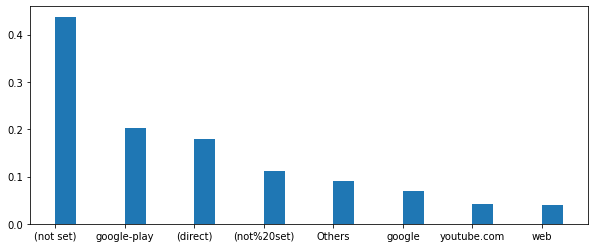

In [21]:
import matplotlib.pyplot as plt

names = list(effect.keys())
values = list(effect.values())

print(effect)
plt.figure(figsize=(10, 4))  # width:20, height:3
plt.bar(range(len(effect)), values, tick_label=names, align='edge', width=0.3)
plt.show()


In [22]:

list_of_paths2= list(tuple(str(tuple(i)) for i in list_of_paths))
list_of_unique_paths=list(set(str(tuple(i)) for i in list_of_paths))
#list_of_unique_paths
freq_paths=dict()
for i in list_of_unique_paths:
    freq_paths[i]=0
for path in list_of_paths2:
    if path in freq_paths:
        freq_paths[path]+=1


In [23]:
freq_paths=dict(sorted(freq_paths.items(), key=lambda item: item[1],reverse=True))
res = dict(list(freq_paths.items())[0: 50])

In [24]:
res

{"('Start', '(direct)', 'Null')": 1248001,
 "('Start', '(not set)', 'Null')": 1203288,
 "('Start', 'google-play', 'Null')": 477746,
 "('Start', 'Others', 'Null')": 457662,
 "('Start', '(not set)', 'Conversion')": 438063,
 "('Start', '(not%20set)', 'Null')": 397549,
 "('Start', 'google-play', 'Conversion')": 174050,
 "('Start', '(direct)', 'Conversion')": 154587,
 "('Start', 'google', 'Null')": 138906,
 "('Start', 'youtube.com', 'Null')": 100542,
 "('Start', '(not%20set)', 'Conversion')": 98938,
 "('Start', 'Others', 'Conversion')": 55552,
 "('Start', '(direct)', 'Others', 'Null')": 32185,
 "('Start', '(not set)', 'Others', 'Null')": 31597,
 "('Start', '(not set)', 'google-play', 'Null')": 30673,
 "('Start', 'youtube.com', 'Conversion')": 28452,
 "('Start', 'google', 'web', 'Null')": 26345,
 "('Start', '(direct)', 'google', 'Null')": 25987,
 "('Start', 'google', 'Conversion')": 25248,
 "('Start', '(not set)', 'google', 'Null')": 23827,
 "('Start', '(not set)', 'google-play', 'Conversion

In [25]:
with open('path_freq.csv', 'w') as f:
    for key in res.keys():
        f.write("%s,%s\n"%(key,res[key]))

In [26]:
count=0

for i in list_of_paths:
    for j in i:
        if j in ['Null'] and (len(i)==4):
            count+=1
print(count)

434228


In [27]:
count=0

for i in list_of_paths:
    if (len(i)>4):
            count+=1
print(count)

148215
